In [6]:
import pandas as pd
import numpy as np
import csv
import glob
import scipy
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from datetime import datetime, timezone, timedelta
import voltaiq_studio as vs

In [7]:
trs = vs.get_test_records() # Load All Test Records
filtered_trs = []
# search for iphone test records
#tr_search = ['Attia_2020_CellID']
tr_search = ['Attia_2020_CellID','Severson_2019_CellID','Attia_predicted_capacity_CellID','Baumhoefer_2014_CellID','dechent_2017_CellID','dechent_2020_CellID']
def filter_test_record_by_name(name):
    return [t for t in trs if name.lower() in t.name.lower()]
for i in tr_search:
    filtered_trs.append(filter_test_record_by_name(i))
print(len(filtered_trs[5]))
filtered_trs[5].remove(filtered_trs[5][14])
print(len(filtered_trs[5]))

22
21


In [13]:
def extract_data(data, time='h_test_time'):
    n_cells=[]
    exp_time=0
    df = {}
    for m in range(len(data)):
        # set time = 'cycle' to perform analysis of capacity against cycles
        reader = data[m].make_time_series_reader()
        #trace_keys = data.trace_keys
        #print(trace_keys)
        reader.add_trace_keys('h_current', 'h_potential','h_test_time','h_cycle','aux_vdf_cellid_none_0','aux_vdf_capacity_amp-hour_0')
        #reader.add_info_keys('i_cycle_num')
        d = reader.read_pandas()
        n_cells=np.max(len(data))
        if np.max(d[time])>exp_time:
            exp_time=np.max(d[time])
        dtemp={}
        #cell_data = d.loc[d['aux_vdf_cellid_none_0'] == m]
        df[m+1]=np.array([d[time], d['aux_vdf_capacity_amp-hour_0']])
    return df, n_cells, exp_time

In [9]:
def linear_slope(x,y):
    # fits a linear regression model to data and returns the slope of the fit
    reg = LinearRegression().fit(x, y)
    return reg.coef_[0]

In [10]:
def calculate_n_online(df, n_cells, experiment_time,
                       max_acceptable_dev=25, confidence_level=68,
                       percs=[1], n_boot_samples=1000):
    best_ns = {}
    
    for perc in percs:
        slopes = []
        for i in range(1, n_cells+1):
            x = np.array(df[i][0])
            y = np.array(df[i][1])

            y = y[x <= perc * experiment_time]
            x = x[x <= perc * experiment_time]

            x = x.reshape(-1, 1)
            
            if len(x) == 0:
                slopes.append(np.nan)
            else:
                slopes.append(linear_slope(x, y))


        sigma_hat = np.std(slopes)

        emp_RSEs = []
        best_n = n_cells

        for n in range(2, n_cells+1):
            boot_SEs = []
            for boot in range(n_boot_samples):
                random_cells = np.random.randint(0, high=n_cells, size=n)
                samples = []
                for cell in random_cells:
                    samples.append(slopes[cell])
                boot_SEs.append(np.std(samples))
            RSE = 100*np.std(boot_SEs)/sigma_hat
            
            emp_RSEs.append(RSE)
            
            q = - max_acceptable_dev/RSE
            prob = 100*(1-2*scipy.stats.norm.cdf(q))
            
            if prob >= confidence_level:
                if not best_ns.get(np.round(100*perc)):
                    best_ns[np.round(100*perc)] = n
                
    return best_ns

In [11]:
def calculate_RSEs_and_probs(df, n_cells,
                             max_acceptable_dev=25,
                             n_boot_samples = 1000):
    slopes = []
    for i in range(1, n_cells+1):
        x = np.array(df[i][0])
        y = np.array(df[i][1])

        x = x.reshape(-1, 1)
        
        if len(x) == 0:
            slopes.append(np.nan)
        else:
            slopes.append(linear_slope(x, y))


    theo_RSE = [100 / np.sqrt(2*n) for n in range(1, n_cells)]


    sigma_hat = np.std(slopes)

    n_boot_samples = 1000
    emp_RSEs = []        
    probs_emp = []
    probs_theo = []
    
    for n in range(2, n_cells+1):
        boot_SEs = []
        for boot in range(n_boot_samples):
            random_cells = np.random.randint(0, high=n_cells, size=n)
            samples = []
            for cell in random_cells:
                samples.append(slopes[cell])
            boot_SEs.append(np.std(samples))
            
        RSE = 100*np.std(boot_SEs)/sigma_hat
        
        emp_RSEs.append(RSE)

        ## calculating probabilities via standard normal
        q_emp = -  max_acceptable_dev/RSE
        probs_emp.append(100*(1-2*scipy.stats.norm.cdf(q_emp)))
        
        q_theo = -  max_acceptable_dev/theo_RSE[n-2]
        probs_theo.append(100*(1-2*scipy.stats.norm.cdf(q_theo)))


    return emp_RSEs, theo_RSE, probs_emp, probs_theo

In [14]:
attia_pred_df, n_cells_attia_pred, exp_time_attia_pred = extract_data(filtered_trs[2])
sev_df, n_cells_sev, exp_time_sev = extract_data(filtered_trs[1])
attia_df, n_cells_attia, exp_time_attia = extract_data(filtered_trs[0])
baum_df, n_cells_baum, exp_time_baum = extract_data(filtered_trs[3])
dech_1_df, n_cells_dech_1, exp_time_dech_1 = extract_data(filtered_trs[4])
dech_2_df, n_cells_dech_2, exp_time_dech_2 = extract_data(filtered_trs[5])
#print(dech_2_df, n_cells_dech_2, exp_time_dech_2)

In [15]:
print('-----------')
print('Attia pred')
print(calculate_n_online(attia_pred_df, n_cells_attia_pred,
                         exp_time_attia_pred, percs=np.arange(0.2, 1.2, 0.2)))
print('-----------\n')

print('Attia')
print(calculate_n_online(attia_df, n_cells_attia,
                         exp_time_attia, percs=np.arange(0.2, 1.2, 0.2)))
print('-----------\n')

print('Dechent 2017')
print(calculate_n_online(dech_1_df, n_cells_dech_1,
                         exp_time_dech_1, percs=np.arange(0.2, 1.2, 0.2)))
print('-----------\n')

print('Dechent 2020')
print(calculate_n_online(dech_2_df, n_cells_dech_2,
                         exp_time_dech_2, percs=np.arange(0.2, 1.2, 0.2)))
print('-----------\n')

print('Severson')
print(calculate_n_online(sev_df, n_cells_sev,
                         exp_time_sev, percs=np.arange(0.2, 1.2, 0.2)))
print('-----------\n')


print('Baum')
print(calculate_n_online(baum_df, n_cells_baum,
                         exp_time_baum, percs=np.arange(0.2, 1.2, 0.2)))
print('-----------\n')

-----------
Attia pred
{20.0: 19, 40.0: 17, 60.0: 16, 80.0: 8, 100.0: 11}
-----------

Attia
{20.0: 11, 40.0: 26, 60.0: 5, 80.0: 10, 100.0: 8}
-----------

Dechent 2017
{40.0: 7, 60.0: 12, 80.0: 8, 100.0: 10}
-----------

Dechent 2020
{20.0: 8, 40.0: 7, 60.0: 7, 80.0: 10, 100.0: 9}
-----------

Severson
{20.0: 45, 40.0: 18, 60.0: 17, 80.0: 6, 100.0: 9}
-----------

Baum
{20.0: 7, 40.0: 12, 60.0: 7, 80.0: 7, 100.0: 8}
-----------



In [16]:
# collecting data for plotting
dfs = [sev_df,  baum_df, attia_df, dech_1_df, dech_2_df, attia_pred_df]

n_cells = [n_cells_sev,  n_cells_baum, n_cells_attia,
           n_cells_dech_1, n_cells_dech_2, n_cells_attia_pred]

## Titles for plots
titles = ['Severson-2019', 'Baumhofer-2014', 'Attia-2020',
          'Dechent-2017', 'Dechent-2020', 'Attia-predicted']

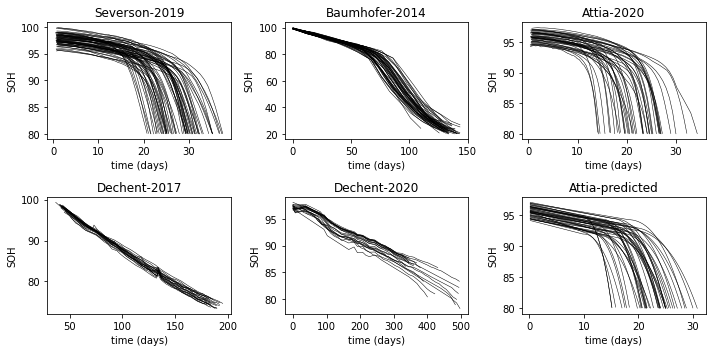

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b

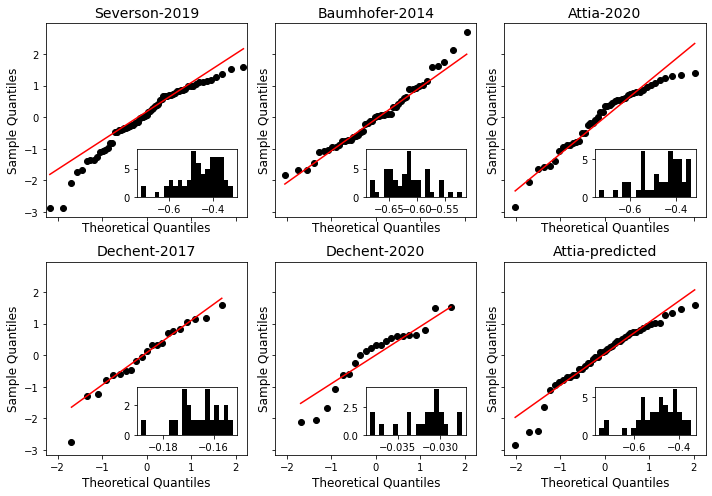

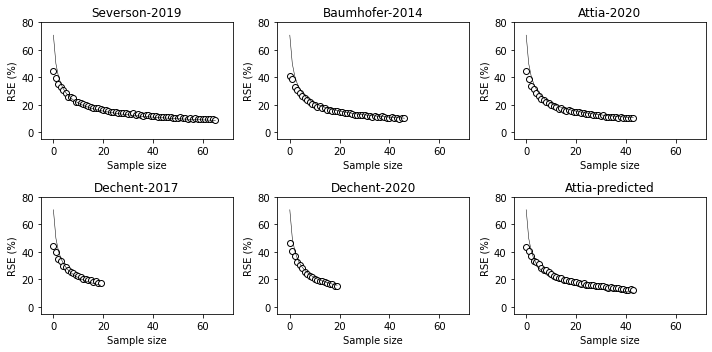

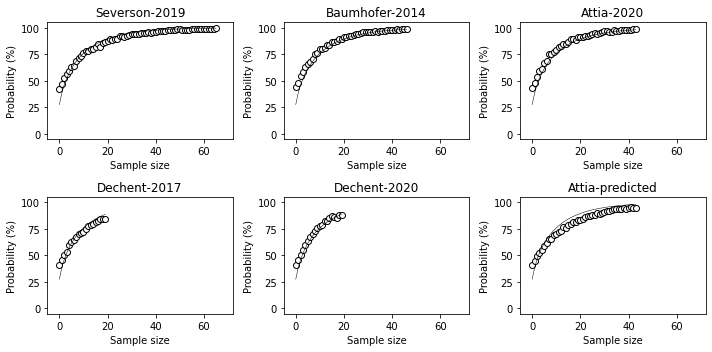

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b

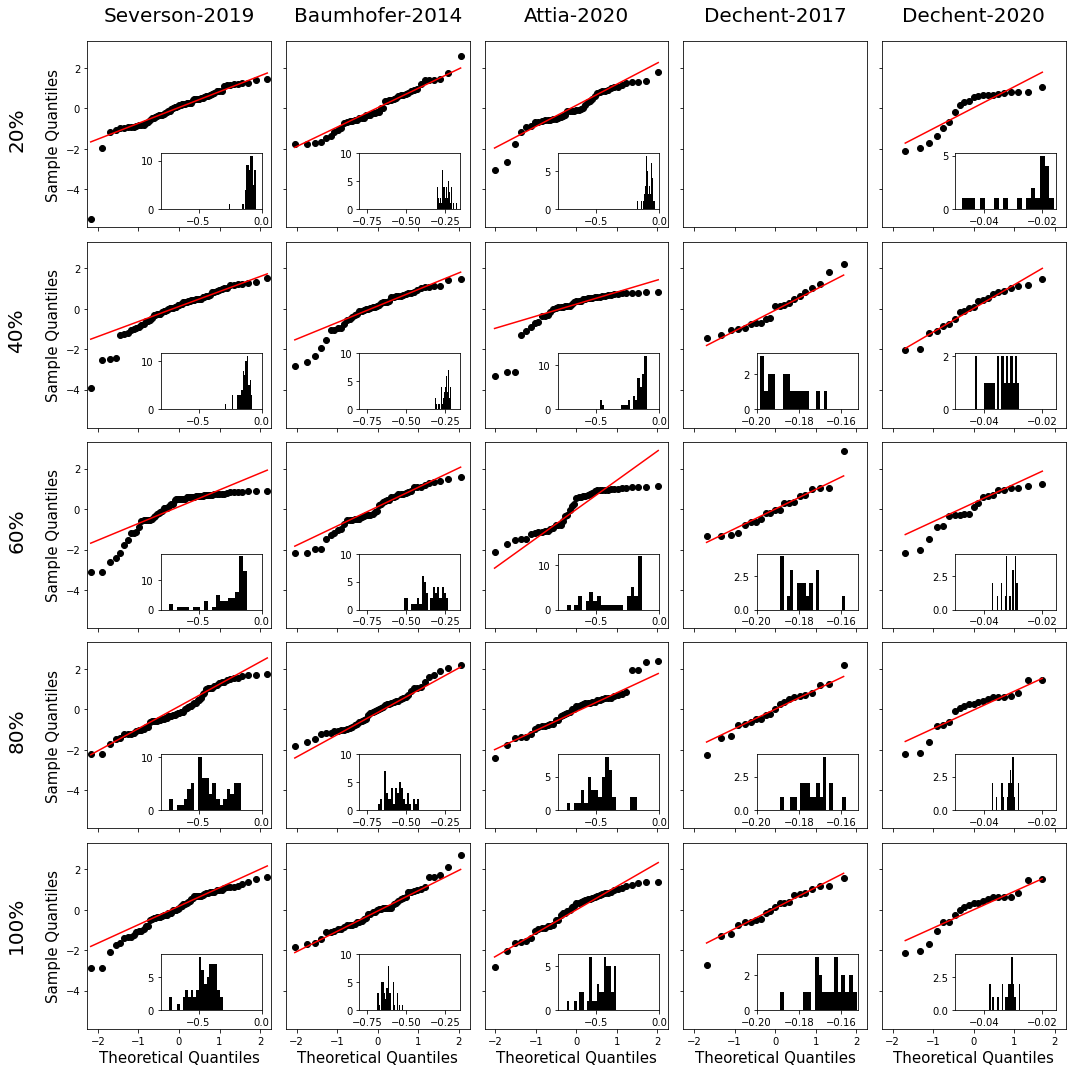

In [17]:
### Plot of capacity curves
fig, axs = plt.subplots(2,3, figsize=(10,5))

j = 0
for i, df in enumerate(dfs):
    axs[j,i%3].set_title(titles[i])
    axs[j,i%3].set_xlabel('time (days)')
    axs[j,i%3].set_ylabel('SOH')
    for cell in df.keys():
        axs[j, i%3].plot(df[cell][0], df[cell][1], c='k', lw=0.5)
    if i == 2:
        j+=1
        
        
fig.tight_layout()
plt.savefig('./plots/data_against_time.pdf')
plt.show()


### QQ plots at 100%
fig, axs = plt.subplots(2,3, figsize=(10,7), sharey=True, sharex=True)

j = 0
for i, df in enumerate(dfs):
    axs[j,i%3].set_title(titles[i], size=14)
    axs[j,i%3].set_xlabel('Theoretical quantiles', size=12)
    axs[j,i%3].set_ylabel('Sample quantiles,', size=12)
    
    slopes = []
    for cell in range(1, n_cells[i]+1):
        x = np.array(df[cell][0])
        y = np.array(df[cell][1])

        x = x.reshape(-1, 1)
        
        if len(x) == 0:
            slopes.append(np.nan)
        else:
            slopes.append(linear_slope(x, y))
                
    sm.qqplot((np.array(slopes)-np.mean(slopes))/np.std(slopes), line ='q', ax=axs[j, i%3],
              c='k', markerfacecolor='k')
    
    if len(x)>1:
        axins1 = axs[j,i%3].inset_axes([0.45, 0.1, 0.5, 0.25])
        axins1.hist(np.array(slopes),20, color='k')
        
    if i == 2:
        j+=1
  
fig.tight_layout()
plt.savefig('./plots/Q-Q_plots.pdf')
plt.show()


    
### Plotting RSEs
fig, axs = plt.subplots(2,3, figsize=(10,5))

j = 0
for i, df in enumerate(dfs):
    axs[j,i%3].set_title(titles[i])
    axs[j,i%3].set_xlabel('Sample size')
    axs[j,i%3].set_ylabel('RSE (%)')
    axs[j,i%3].set_xlim(-5, np.max(n_cells) + 5)
    axs[j,i%3].set_ylim(-5, 80)
    emp_RSE, theo_RSE, _, _ = calculate_RSEs_and_probs(df, n_cells[i])
    axs[j, i%3].plot(theo_RSE, c='k', lw=0.5)
    axs[j, i%3].scatter(np.arange(len(emp_RSE)), emp_RSE, c='white', edgecolor='k')
    if i == 2:
        j+=1      
        
fig.tight_layout()
plt.savefig('./plots/RSEs_emp_and_theo.pdf')
plt.show()


### Plotting Probabilities

fig, axs = plt.subplots(2,3, figsize=(10,5))

j = 0
for i, df in enumerate(dfs):
    axs[j,i%3].set_title(titles[i])
    axs[j,i%3].set_xlabel('Sample size')
    axs[j,i%3].set_ylabel('Probability (%)')
    axs[j,i%3].set_xlim(-5, np.max(n_cells) + 5)
    axs[j,i%3].set_ylim(-5, 105)
    _, _, probs_emp, probs_theo = calculate_RSEs_and_probs(df, n_cells[i])
    axs[j, i%3].plot(probs_theo, c='k', lw=0.5)
    axs[j, i%3].scatter(np.arange(len(probs_emp)), probs_emp, c='white', edgecolor='k')
    if i == 2:
        j+=1      
        
fig.tight_layout()
plt.savefig('./plots/probs_emp_and_theo.pdf')
plt.show()



### QQ plots with percentage of input

## here we don't plot the Attia predicted datset

dfs = [sev_df,  baum_df, attia_df, dech_1_df, dech_2_df]
n_cells = [n_cells_sev,  n_cells_baum, n_cells_attia,
           n_cells_dech_1, n_cells_dech_2]

exp_times = [exp_time_sev,  exp_time_baum, exp_time_attia,
           exp_time_dech_1, exp_time_dech_2]

fig, axs = plt.subplots(5,5, figsize=(15,15), sharex=True, sharey=True)

j=0

for perc in np.arange(0.2, 1.2, 0.2):   
    for i, df in enumerate(dfs):
        axs[j,i].set_xlabel('')
        axs[j,i].set_ylabel('rty')
        slopes = []
        for cell in range(1, n_cells[i]+1):
            x = np.array(df[cell][0])
            y = np.array(df[cell][1])
            
            y = y[x <= perc * exp_times[i]]
            x = x[x <= perc * exp_times[i]]
    
            x = x.reshape(-1, 1)
            
            if len(x) == 0:
                slopes.append(np.nan)
            else:
                slopes.append(linear_slope(x, y))
                    
        sm.qqplot((np.array(slopes)-np.mean(slopes))/np.std(slopes), line ='q', ax=axs[j, i],
                  c='k', markerfacecolor='k', xlabel='', ylabel='')
        if len(x)>1:
            axins1 = axs[j,i].inset_axes([0.4, 0.1, 0.55, 0.3])
            axins1.hist(np.array(slopes),20, color='k')
           
            if i == 0:
                axins1.set_xlim([-0.8, 0])

            elif i == 1:
                axins1.set_xlim([-0.8, -0.15])

                axins1.set_ylim([0, 10])
            elif i == 2:
                axins1.set_xlim([-0.8, 0])

            elif i == 3 :
                axins1.set_xlim([-0.2, -0.152])

            else:
                axins1.set_xlim([-0.05, -0.015])


    j+=1
    for k in range(5):
        axs[4,k].set_xlabel('Theoretical Quantiles', size=15)
        axs[k,0].set_ylabel('Sample Quantiles', size=15)
        axs[0,k].set_title(titles[k], size=20, pad=20)        
        
axs[0,0].annotate('20%', (-80,80), xycoords='axes points', size=20, rotation='vertical')
axs[1,0].annotate('40%', (-80,80), xycoords='axes points', size=20, rotation='vertical')
axs[2,0].annotate('60%', (-80,80), xycoords='axes points', size=20, rotation='vertical')
axs[3,0].annotate('80%', (-80,80), xycoords='axes points', size=20, rotation='vertical')
axs[4,0].annotate('100%', (-80,80), xycoords='axes points', size=20, rotation='vertical')
            
fig.tight_layout()
plt.savefig('./plots/Q-Q_plots_different_percs.pdf')
plt.show()